Bureau of Labor Statistics API with Python
======

## Unemployment rates by race/origin 

------

*September 3, 2017*<br>
*@bd_econ*

BLS API documentation is [here](https://www.bls.gov/developers/)

This example collects data on the unemployment rate for Whie, Black, and Hispanic populations in the US and plots the results.

In [1]:
%matplotlib inline
import pandas as pd
import requests
import json

api_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

# API key in config.py which contains: bls_key = 'key'
import config
key = '?registrationkey={}'.format(config.bls_key)

## Parameters/ Date handling

The BLS API limits how many years of data can be returned in a request. The small while loop below splits a date range into chunks that the BLS API will accept.

In [2]:
# Series stored as a dictionary
series_dict = {
    'LNS14000003': 'White', 
    'LNS14000006': 'Black', 
    'LNS14000009': 'Hispanic'}

# Start year and end year
date_r = (1975, 2017)

# Handle dates
dates = [(str(date_r[0]), str(date_r[1]))]
while int(dates[-1][1]) - int(dates[-1][0]) > 10:
    dates = [(str(date_r[0]), str(date_r[0]+9))]
    d1 = int(dates[-1][0])
    while int(dates[-1][1]) < date_r[1]:
        d1 = d1 + 10
        d2 = min([date_r[1], d1+9])
        dates.append((str(d1),(d2))) 

## Get the data

In [3]:
df = pd.DataFrame()

for start, end in dates:
    # Submit the list of series as data
    data = json.dumps({
        "seriesid": series_dict.keys(),
        "startyear": start, "endyear": end})

    # Post request for the data
    p = requests.post(
        '{}{}'.format(api_url, key), 
        headers={'Content-type': 'application/json'}, 
        data=data).json()
    for s in p['Results']['series']:
        col = series_dict[s['seriesID']]
        for r in s['data']:
            date = pd.to_datetime('{} {}'.format(
                r['periodName'], r['year']))
            df.set_value(date, col, float(r['value']))
df = df.sort_index()
# Output results
print('Post Request Status: {}'.format(p['status']))
df.tail(13)

C:\Users\BDew\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Post Request Status: REQUEST_SUCCEEDED


,White,Hispanic,Black
2016-11-01,4.2,5.7,8.0
2016-12-01,4.3,5.9,7.8
2017-01-01,4.3,5.9,7.7
2017-02-01,4.1,5.6,8.1
2017-03-01,3.9,5.1,8.0
2017-04-01,3.8,5.2,7.9
2017-05-01,3.7,5.2,7.5
2017-06-01,3.8,4.8,7.1
2017-07-01,3.8,5.1,7.4
2017-08-01,3.9,5.2,7.7


## Plot the results

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)

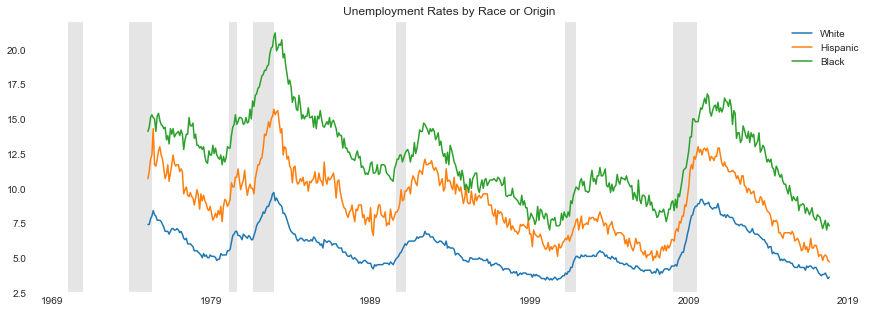

In [5]:
df.plot(title='Unemployment Rates by Race or Origin', figsize=(15, 5))

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, 
                linewidth=0, color='gray', alpha=0.2)  

In [3]:
pd.read_csv('rec_dates.csv')[-2:]

,peak,trough
5,2001-04-01,2001-12-01
6,2008-01-01,2009-07-01


In [5]:
for i, v in [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]:
    plt.axvspan(v['peak'], v['trough'], fill=True, 
                linewidth=0, color='gray', alpha=0.2)  

2001-04-01
2008-01-01
